In [3]:
from PIL import Image
from typing import Optional, List, Literal
from pydantic import BaseModel, Field

MODEL_NAME = "Qwen/Qwen3-VL-2B-Instruct"

In [4]:
from transformers import AutoConfig
from enum import Enum

mask_config = AutoConfig.from_pretrained("facebook/mask2former-swin-large-ade-semantic")
mask_labels = [i.upper() for i in mask_config.id2label.values()]
MaskLabels = Enum(
    "MaskLabel", {i.upper(): i.upper() for i in mask_config.id2label.values()}
)

In [5]:
class LandmarkSubject(BaseModel):
    subject_name: str
    label: MaskLabels = Field(description="best fit label to describe the subject")
    score: float = Field(
        description="how much the subject represent the landmark itself. primary subject must have higher score than secondary subjects."
    )
    is_primary: int = Field(
        description="binary label indicates if the identified subject is primary or not."
    )


class ImageLandmark(BaseModel):
    landmark_prob: float = Field(
        description="probability score between 0 to 1 that indicates if the given image is classified as landmark"
    )
    reason: str = Field(
        description="descriptive reasoning of why such decision has been made."
    )
    subject: List[LandmarkSubject] = Field(
        description="primary and secondary subjects identified in the image along with labels and scores. the total score from all subjects must be 1."
    )

In [6]:
prompt = f"""You are a strict JSON generator. You classify whether an image is a TOURISM-RELATED LANDMARK photo and extract subjects.

IMPORTANT SEMANTICS:
- landmark_prob is a FLOAT in [0.0, 1.0].
- landmark_prob means: "How likely is it that this image is mainly about a tourism landmark (landmark is the PRIMARY SUBJECT and focus)?"
- If a landmark appears only in the background, landmark_prob must be LOW (usually <= 0.35).

DEFINITIONS (tourism field only):
A tourism landmark is a DISTINCT, STATIONARY place-feature that tourists commonly visit or photograph,
e.g., towers, temples, castles, monuments, iconic bridges, famous historic buildings, famous viewpoints,
distinctive natural attractions (mountains, waterfalls).

Hard negatives (NOT landmark photos):
- vehicles as main subject (cars, buses, fire trucks, trains)
- people close-ups / portraits as main subject
- generic streets or generic buildings as main subject
- temporary events (accidents, emergency response), unless a landmark is clearly the main focus

YOU WILL RECEIVE TWO LISTS:
- MASK_LABELS: all allowed labels
- LANDMARK_LABELS: subset of labels that count as landmark-types (e.g., tower/temple/monument/bridge/etc.)

SUBJECT EXTRACTION RULES:
1) Always output at least 1 subject.
2) Exactly ONE subject must have "is_primary": 1. All others must have "is_primary": 0.
3) subject_name must be a short noun phrase (2-6 words).
4) Primary subject = visually dominant/main focus (largest, central, or most salient).
5) Secondary subjects = other important entities (max 4).
6) Choose label ONLY from MASK_LABELS. Never invent labels.

SCORING RULES (subject.score):
- score is a salience distribution over subjects (how much each subject dominates the image content).
- Sum of all subject scores MUST equal 1.0 (allow 0.9999–1.0001).
- Primary subject score MUST be strictly greater than any secondary score.

LANDMARK PROBABILITY RULE (landmark_prob):
Step A (HARD GATE):
- If the PRIMARY subject label is NOT in LANDMARK_LABELS, then landmark_prob MUST be <= 0.20.
  (Example: primary label vehicle/person/street/building_generic -> landmark_prob <= 0.20)

Step B (FOCUS CHECK, only if primary label is in LANDMARK_LABELS):
Compute 4 cues (0/1):
  A. Distinctive silhouette/architecture/natural shape
  B. Looks like a specific recognizable POI (iconic/unique)
  C. Tourist framing/cues (viewpoint composition, signage/plaque, crowds photographing)
  D. Landmark dominates the image clearly (not occluded by vehicles/people)
Score = A+B+C+D (0..4)

Map to landmark_prob (float):
- Score 4 -> 0.95–0.99
- Score 3 -> 0.80–0.94
- Score 2 -> 0.55–0.79
- Score 1 -> 0.30–0.54
- Score 0 -> 0.05–0.29

BACKGROUND LANDMARK RULE:
- If a landmark-type exists only as a SECONDARY subject and the PRIMARY subject is non-landmark (vehicle/person/event),
  keep landmark_prob LOW (<= 0.35, and usually <= 0.20 due to HARD GATE).

REASON RULES:
- reason must be 1–2 short sentences.
- Must mention the primary subject and whether the landmark is the focus or only background.
- Do not mention scoring rules.

OUTPUT RULES:
- Output ONLY valid JSON (double quotes, no trailing commas, no markdown, no extra text).
- Do not include any keys other than: subject, landmark_prob, reason.

Return the information in the following JSON schema:
{ImageLandmark.model_json_schema()}
"""

In [14]:
import base64
from openai import AsyncOpenAI
import asyncio

client = AsyncOpenAI(base_url="https://allowing-believes-specializing-nevada.trycloudflare.com/v1", api_key="227a1c19166b2e90c46459a029f9b7bea8a3d4b0a72f816550e0db66c3f4dc42")
semaphore = asyncio.Semaphore(10)


# Helper function to encode a local image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def build_message(img_path, prompt):
    # Path to your image
    # image_path = "./Tokyo_Skytree_2014.jpg"
    base64_image = encode_image(img_path)
    return [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {
                    "type": "image_url",
                    "image_url": {
                        # You can use a URL: "url": "https://example.com/image.jpg"
                        # Or Base64:
                        "url": f"data:image/jpeg;base64,{base64_image}"
                    },
                },
            ],
        }
    ]


async def llm_call(semaphore, messages: List, idx: int):
    async with semaphore:
        response = await client.beta.chat.completions.parse(
            model="OpenGVLab/InternVL3_5-14B-HF",
            messages=messages,
            response_format=ImageLandmark,
            max_tokens=1024,
            temperature=0,
        )
        return idx, response.choices[0].message.parsed.model_dump_json()


In [15]:
import polars as pl

df = pl.read_csv("../datasets/mp16-reason-train.csv")
img_paths = df["IMG_ID"].to_list()[:5]

In [16]:
import os
from tqdm import tqdm

responses = [None] * 5
basepath = "../datasets/mp16-reason/"

tasks = []
for ii, item in enumerate(img_paths[:5]):
    msg = build_message(os.path.join(basepath, item), prompt)
    tasks.append(asyncio.create_task(llm_call(semaphore, msg, ii)))

for coro in tqdm(asyncio.as_completed(tasks), total=len(tasks)):
    i, res = await coro
    responses[i] = res

  0%|          | 0/5 [01:59<?, ?it/s]


CancelledError: 

In [100]:
import json

valid_item = []
invalid_idx = []

with open("../mp16-reason-landmark-annot.jsonl", "r") as f:
    data = f.readlines()
    for ii, d in enumerate(data):
        d = json.loads(d)
        if d:
            valid_item.append(d)
        else:
            invalid_idx.append(ii)

In [106]:
df_valid = pl.DataFrame(valid_item).with_row_index("idx")
df_filtered = df.with_row_index("idx").filter(~pl.col("idx").is_in(invalid_idx))
df_filtered = df_filtered.drop("idx").with_row_index("idx")


In [152]:
ImageLandmark(**valid_item[0]).subject[0].model_dump()

{'subject_name': 'monument',
 'label': <MaskLabel.MONITOR: 'MONITOR'>,
 'score': 0.95,
 'is_primary': 1}

In [154]:
df["reason"]

reason
str
"""The architecture in the backgr…"
"""The structure in the image is …"
"""The image shows a suspension b…"
"""The image features a sign that…"
"""The architecture in the image …"
…
"""The architecture suggests a Eu…"
"""The architecture in the backgr…"
"""The architecture in the image …"


In [118]:
df_filtered.join(df_valid, on="idx").filter(pl.col("landmark_prob") > 0.5)

idx,IMG_ID,AUTHOR,LAT,LON,S3_Label,S16_Label,S365_Label,Prob_indoor,Prob_natural,Prob_urban,neighbourhood,city,county,state,region,country,country_code,continent,reason,entities,landmark_prob,reason_right,subject
u32,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,f64,str,list[struct[4]]
0,"""11_53_8635985905.jpg""","""75394383@N00""",41.895733,12.484013,2.0,12.0,53.0,0.030819,0.003451,0.96573,"""Municipio Roma I""","""Rome""","""Roma Capitale""","""Lazio""",null,"""Italy""","""it""",null,"""The architecture in the backgr…","""[{'text': 'white building', 't…",0.95,"""The primary subject is the lar…","[{""monument"",""MONITOR"",0.95,1}, {""person"",""PERSON"",0.05,0}]"
1,"""84_3a_3207322187.jpg""","""44124431847@N01""",48.872968,2.297462,2.0,11.0,12.0,8.8682e-7,0.004482,0.995517,"""Paris""","""Paris""",null,"""Ile-de-France""","""Metropolitan France""","""France""","""fr""",null,"""The structure in the image is …","""[{'text': 'Arc de Triomphe', '…",0.96,"""The primary subject is the ico…","[{""Arc de Triomphe"",""SKYSCRAPER"",0.95,1}, {""car"",""CAR"",0.05,0}, … {""street"",""ROAD"",0.01,0}]"
2,"""8a_4b_6754899341.jpg""","""35065505@N03""",51.465985,-2.554528,2.0,10.0,291.0,0.00751,0.305245,0.687244,"""Whitehall""","""Bristol""","""City of Bristol""","""England""",null,"""United Kingdom""","""gb""",null,"""The image shows a suspension b…","""[{'text': 'suspension bridge',…",0.95,"""The primary subject is the ico…","[{""bridge"",""BRIDGE"",0.95,1}, {""person"",""PERSON"",0.05,0}]"
4,"""b3_7a_3710179682.jpg""","""36344312@N04""",51.208291,3.224701,2.0,15.0,348.0,0.000967,0.014436,0.984597,"""Brugge""","""Bruges""","""Brugge""","""West Flanders""",null,"""Belgium""","""be""",null,"""The architecture in the image …","""[{'text': 'red-tiled roofs', '…",0.95,"""The primary subject is a disti…","[{""tower"",""TOWER"",0.95,1}]"
5,"""b9_e3_442209740.jpg""","""7596469@N04""",43.325552,-1.978397,2.0,15.0,245.0,0.001529,0.06137,0.937101,"""Gros""","""San Sebastián""",null,"""Autonomous Community of the Ba…",null,"""Spain""","""es""",null,"""The architecture of the buildi…","""[{'text': 'building', 'type': …",0.95,"""The primary subject is the mod…","[{""building"",""BUILDING"",0.95,1}]"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
33011,"""28_ff_2541960721.jpg""","""59011401@N00""",54.679411,25.287845,2.0,15.0,181.0,0.002435,0.001899,0.995667,"""Old Town""","""Vilnius""",null,"""Vilnius County""",null,"""Lithuania""","""lt""",null,"""The image shows a square with …","""[{'text': 'square', 'type': 'A…",0.95,"""The primary subject is the fou…","[{""fountain"",""FOUNTAIN"",0.95,1}]"
33014,"""d5_f5_1125740702.jpg""","""56843436@N00""",51.503774,-0.119454,2.0,12.0,7.0,0.000752,0.000513,0.998735,"""London Borough of Lambeth""","""London""",null,"""England""",null,"""United Kingdom""","""gb""",null,"""The image shows a large Ferris…","""[{'text': 'Ferris wheel', 'typ…",0.95,"""The primary subject is the Lon…","[{""London Eye"",""WATER"",0.99,1}]"
33015,"""9c_29_9743633874.jpg""","""84989911@N00""",53.3438,-6.256133,0.0,5.0,212.0,0.96904,0.001051,0.029909,"""Mansion House A Ward 1986""","""Dublin""","""County Dublin""",null,"""Leinster""","""Ireland""","""ie""",null,"""The architecture in the image …","""[{'text': 'tall wooden ceiling…",0.95,"""The primary subject is the gra…","[{""library"",""BUILDING"",0.95,1}, {""people"",""PERSON"",0.05,0}]"


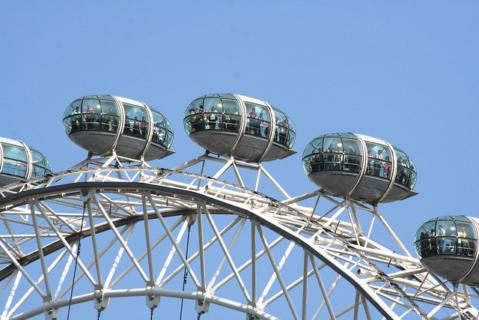

In [125]:
basepath = "../datasets/mp16-reason"

Image.open(os.path.join(basepath, "d5_f5_1125740702.jpg"))

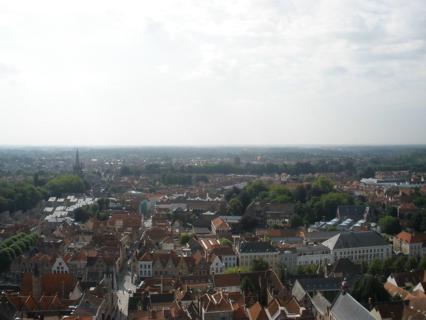

In [2]:
from PIL import Image

Image.open("../datasets/mp16-reason/b3_7a_3710179682.jpg")